# Stochastic Partial Derivative Equations

<!-- SUMMARY: Estimation and Simulations performed in the framework of SPDE -->

<!-- CATEGORY: SPDE -->

In this tutorial, we show how to use the API SPDE

In [ ]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import matplotlib.pyplot as plt

from sksparse.cholmod import cholesky
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Parameters

In [ ]:
# Data
np.random.seed(123)
ndat = 1000

# Model
rangev = 0.2
sill = 1.
nugget = 0.1

# Grid 
nx = [50,50]
dx = [0.02,0.02]
x0 = [0,0]

#Grid meshing
nxm = [75,75]
dxm = [0.02,0.02]
x0m = [-0.25,-0.25]

dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True, names=["spde*"])

### Grid and Meshing

In [ ]:
grid = gl.DbGrid.create(nx,dx,x0)
gridExt = gl.DbGrid.create(nxm,dxm,x0m)
mesh = gl.MeshETurbo(gridExt)

### Model

In [ ]:
model = gl.Model.createFromParam(gl.ECov.MATERN,param=1,range=rangev,sill=sill)
model.addCovFromParam(gl.ECov.NUGGET,sill=nugget)

### Data

In [ ]:
dat = gl.Db.create()
dat["x"] = np.random.uniform(size=ndat)
dat["y"] = np.random.uniform(size=ndat)
dat.setLocators(["x","y"],gl.ELoc.X)

## SPDE non-conditional simulation

### Grid query

In [ ]:
spde = gl.SPDE(model,grid,None,gl.ESPDECalcMode.SIMUNONCOND)
gl.law_set_random_seed(131351)
iuid = spde.compute(grid)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 2500

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.020     0.020
Number :         50        50

Data Base Statistics
--------------------
4 - Name spde - Locator z1
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -3.342
 Maximum value       =      3.300
 Mean value          =     -0.121
 Standard Deviation  =      1.007
 Variance            =      1.014

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = spde - Locator = z1


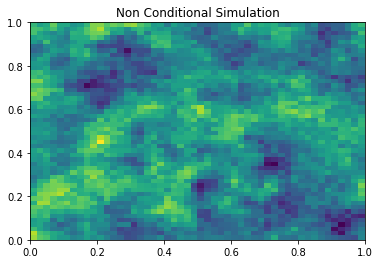

In [ ]:
gp.plot(grid)
gp.decoration(title="Non Conditional Simulation")

### Data query

In [ ]:
gl.law_set_random_seed(131351)
iuid = spde.compute(dat)
dat.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 1000

Data Base Statistics
--------------------
3 - Name spde - Locator z1
 Nb of data          =       1000
 Nb of active values =       1000
 Minimum value       =     -2.993
 Maximum value       =      2.428
 Mean value          =     -0.157
 Standard Deviation  =      1.014
 Variance            =      1.028

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = spde - Locator = z1


## Kriging

In [ ]:
spdeRes = gl.SPDE(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh,1)
iuid = spdeRes.compute(grid)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 2500

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.020     0.020
Number :         50        50

Data Base Statistics
--------------------
4 - Name spde - Locator NA
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -3.342
 Maximum value       =      3.300
 Mean value          =     -0.121
 Standard Deviation  =      1.007
 Variance            =      1.014
5 - Name spde.spde.estim - Locator z1
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -2.554
 Maximum value       =      2.026
 Mean value          =     -0.137
 Standard Deviation  =      0.885
 Variance            =      0.784

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - 

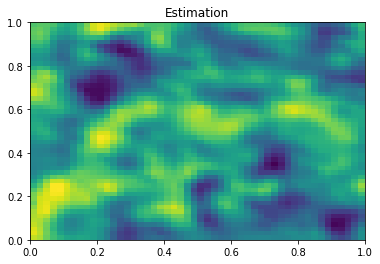

In [ ]:
gp.plot(grid)
gp.decoration(title="Estimation")

## Manually

### Projection Matrix: mesh to grid

In [ ]:
Pglg = gl.ProjMatrix(grid,mesh)
Aprojg = Pglg.toTL()

### Simulation

In [ ]:
Q = spdeRes.getPrecisionOpMatrix().getQ().toTL()
cholQ = cholesky(Q)

Variance = 1.1733


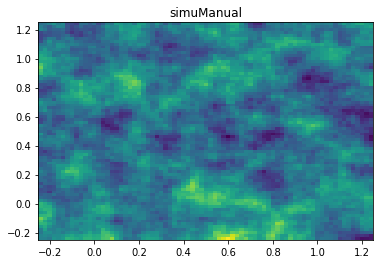

In [ ]:
u = np.random.normal(size = Q.shape[0])
gridExt["simuManual"] = cholQ.apply_Pt(cholQ.solve_Lt(1./np.sqrt(cholQ.D())*u))
gridExt.addSelection((gridExt["x1"]>0) & (gridExt["x2"]>0) & (gridExt["x1"]<1.) & (gridExt["x2"]<1.))

res = gp.plot(gridExt, "simuManual",useSel=False)
print(f"Variance = {round(np.var(gridExt['simuManual'][np.where(gridExt['NewSel']==1)]),4)}")

### Kriging

In [ ]:
Pgl = gl.ProjMatrix(dat,mesh)
Aproj = Pgl.toTL()

Qop = Q + 1/nugget * Aproj.T @ Aproj
cholQop =  cholesky(Qop)

kriging = cholQop.solve_A(Aproj.T @ (dat["spde*"]/nugget))

In [ ]:
grid["manually"] = Aprojg @ kriging

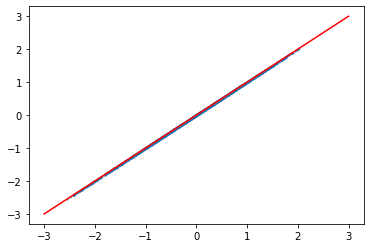

In [ ]:
ax = plt.scatter(grid["manually"],grid["*estim"],s=1)
p = plt.plot([-3,3],[-3,3],c="r")

## Likelihood

Manually with Cholesky vs. matrix-free approach with SPDE api.

In [ ]:
def solveMat(cholQop,x):
    return cholQop.solve_A(x)

def invSigma(sigma2,Aproj,cholQop,x):
    return 1./sigma2 * (x - 1./sigma2 * Aproj @ solveMat(cholQop, Aproj.T @ x))

def detQ(cholQ):
    return cholQ.logdet()

x = dat["spde"]
ones = np.ones_like(x)
invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) 
quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
logdetnoise = len(x) * np.log(nugget)
logdetQ = detQ(cholQ)
logdetQop = detQ(cholQop)
logdet = logdetnoise - logdetQ + logdetQop

print(f"logdet(noise) = {round(logdetnoise,4)}")
print(f"logdet(Q) = {round(logdetQ,4)}")
print(f"logdet(QOp) = {round(logdetQop,4)}")

print(f"logdet_chol = {round(logdet,4)}")
print(f"quad_chol = {round(quad,4)}")
print(f"like_chol = {round(-0.5 * (quad + logdet + len(x) * np.log(2. * np.pi)),4)}")

logdet(noise) = -2302.5851
logdet(Q) = 11255.7151
logdet(QOp) = 12296.9389
logdet_chol = 21250.0689
quad_chol = 1118.4871
like_chol = -12103.2165


In [ ]:
a_quad = spdeRes.computeQuad()
print(f"-> Relative difference quadratic = {round(100*(a_quad-quad)/quad,2)}%")

-> Relative difference quadratic = 0.01%


In [ ]:
pcm = spdeRes.getPrecisionKrig()
a_op = detQ(cholQop)
b_op = pcm.computeLogDetOp(1)
print(f"log_det_op_chol = {round(a_op,4)}")
print(f"log_det_op_api = {round(b_op,4)}")
print(f"-> Relative difference = {round(100*(b_op-a_op)/a_op, 2)}%")

log_det_op_chol = 12296.9389
log_det_op_api = 12296.9389
-> Relative difference = 0.0%


In [ ]:
a_one = detQ(cholQ)
b_one = pcm.computeLogDetQ(10)
print(f"log_det_Q_chol = {round(a_one,4)}")
print(f"log_det_Q_api = {round(b_one,4)}")
print(f"-> Relative difference = {round(100*(b_one-a_one)/a_one,2)}%")

log_det_Q_chol = 11255.7151
log_det_Q_api = 11255.7151
-> Relative difference = 0.0%


In [ ]:
a = -0.5 * (quad + logdet + len(x) * np.log(2. * np.pi))
print(f"likelihood api = {round(a,4)}")

model.setDriftIRF()
spdeLL = gl.SPDE(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh,1)
b = spdeLL.computeLogLikelihood(100)
print(f"likelihood_chol = {round(b,4)}")
print(f"-> Relative Difference = {round(100*(b-a)/a,2)}%")

likelihood api = -847.5015
likelihood_chol = -847.5015
-> Relative Difference = -0.0%


In [ ]:
useCholesky = 1
b2 = gl.logLikelihoodSPDE(dat,model,None,mesh,useCholesky=useCholesky)
print(f"likelihood by Old API with cholesky=1 {round(b2,4)}")

In [ ]:
b2 = gl.logLikelihoodSPDENew(dat,model,useCholesky=useCholesky, verbose=True)
print(f"likelihood by New API with cholesky=1 {round(b2,4)}")

In [ ]:
useCholesky = 0
#b2 = gl.logLikelihoodSPDE(dat,model,None,mesh,useCholesky=useCholesky)
#print(f"likelihood by Old API with cholesky=0 {round(b2,4)}")

In [ ]:
useCholesky = 0
b2 = gl.logLikelihoodSPDENew(dat,model,useCholesky=useCholesky, verbose=True)
print(f"likelihood by New API with cholesky=0 {round(b2,4)}")